# HW 11-2. Image Segmentation with k-Means Clustering

We are about to segment an image into sub-regions based on color similarity. 
For that, we will apply k-means clustering in this homework.
The following code loads an image from the given URL.
The loaded image is in the form of a NumPy n-demensional array.


(512, 768, 3)


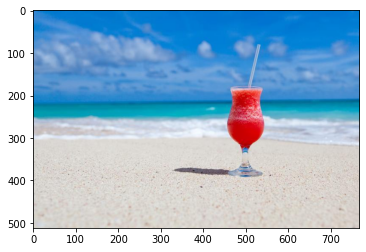

In [ ]:
from copy import deepcopy
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imutils

# load an image from a url
img_url = 'https://snappygoat.com/b/5e3c07f2560b6420543d8e2367a70d3cdb08c39e'
img = imutils.url_to_image(img_url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
imshow(img)
print(img.shape)

Before any pixel-based image processing (e.g., k-means), we first vectorize the image into an array of pixels for the sake of convenience. We represent an image as a 3-dimensional array with each dimension containing r, g, and b values, respectively. 

In [ ]:
pixels = img.reshape((-1,3))
pixels = np.float32(pixels)
print(pixels.shape)

(393216, 3)


We then process the 3d array for a given task. 
Below is a simple blue-light filter that reduces the values of the blue channel. 
Once you processed all pixels, you finally need to reshape the array into the format of a 2D image (i.e., height x width x channels). 

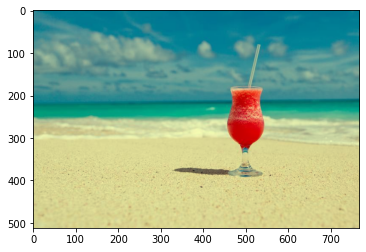

In [ ]:
new_pixels = deepcopy(pixels)
# Blue light filter 
new_pixels[:,2] = new_pixels[:,2] * 0.7
new_pixels = np.uint8(new_pixels)

# Reshape 
result_img = new_pixels.reshape(img.shape)
imshow(result_img)

## T1. Step-by-step implementaion

Here we go through the step-by-step implementation of k-means clustering. 

### Step 1: Initializing k points
We first need to choose initial k positions in the 3d color space. Here we start with k=4. The function ***init()*** is provided to choose the initial positions based on the kmeans++ method. 

In [ ]:
def init(ds, k, random_state=42):
    np.random.seed(random_state)
    centroids = [ds[0]]

    for _ in range(1, k):
        dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in ds])
        probs = dist_sq/dist_sq.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                i = j
                break
        
        centroids.append(ds[i])

    return np.array(centroids)

In [ ]:
k = 4
centroids = init(pixels, k, random_state=42)
print(centroids)
print(pixels)

[[ 24. 133. 202.]
 [222. 219. 214.]
 [111. 101. 110.]
 [106. 179. 198.]]
[[ 24. 133. 202.]
 [ 25. 132. 202.]
 [ 29. 131. 205.]
 ...
 [210. 199. 195.]
 [209. 198. 194.]
 [208. 197. 193.]]


### Step 2: Assigning all points to the closest centroid
Using the initial positions, we now assign all points in pixels to the closest centroid.
As we discussed in the class, "being closest" needs a definition. In other words, we need to measure the similarity between two pixels. 
Consider r, g, b values of a pixel as a coordinate of a point in a 3d space. 
Then we can think of the distance between pixels in the 3D space as a similarity (or distance) measure. 
Here, we simply use Euclidean distance to calculate the similarity between pixels. 


Please complete the following code and answer the following questions. 
*italicized text*

#### Questions:

* Number of pixels in the first cluster? 110736개

In [ ]:
# First centroid
centroids[0]


def distance(a, b):
  return sum([(l_a - l_b)**2 for l_a, l_b in list(zip(a, b))]) ** 0.5

labels = np.zeros(len(pixels))

for i in range(len(pixels)):
  distance_list = np.zeros(k)
  for j in range(k):
    # TODOs: Calculate distances between all points and the initial centroids.
    distance_list[j] = distance(pixels[i], centroids[j])
    # TODOs: Assign all points to their closest centroid.
  labels[i] = np.argmin(distance_list)

print(distance_list)
u, c = np.unique(labels, return_counts=True)
print(dict(zip(u, c)))

[195.02051174  33.48133809 159.73102391 103.69667304]
{0.0: 110736, 1.0: 188634, 2.0: 10483, 3.0: 83363}


### Step 3: Recomputing the centroids

Now we need to recompute centroids for each cluster.
Please complete the code below and answer the questions.



#### Questions:
* Write coordinate of the new cetroid for the first cluster: [19, 132, 202]

Discard the decimal places when answering the question, but you should not round it up in the code.


In [ ]:
centroids_old = deepcopy(centroids)
centroids_new = np.zeros(centroids.shape)

# TODOs: Update centoids

for i in range(k):
  tmp = []
  for j in range(len(pixels)):
    if int(labels[j]) == i:
      tmp.append(pixels[j])
  centroids_new[i] = np.mean(tmp ,axis=0)

print(centroids_new)

[[ 19.42538071 132.62831116 202.48616028]
 [215.86479187 212.52700806 210.17466736]
 [187.49041748  51.19603348  58.72364807]
 [101.03705597 155.76594543 208.87583923]]


#### Questions:
* Calculate the Sum of Squared Error (SSE): 305200965.91

Round to 2 decimal places.


In [ ]:
# TODOs: Calculate SSE
SSE = 0

for i in range(len(pixels)):
  SSE += distance(pixels[i], centroids_new[int(labels[i])])**2
  
print(SSE.round(2))

305200965.91


### Step 4: Repeating step 2 and 3 until convergence

We are now ready to assemble the code snippets into a fully working k-means clustering algorithm.
As we discussed in the class, the algorithm repeats step 2 and step 3. 
The final component left would be how we exit the iteration. 

We can keep tracking SSE and exit the loop when SSE reaches its local minima, which can be simply determined by tracking the changes in centroids' positions in each iteration. 

Complete the code below and answer the questions. 




#### Questions:
* How many iterations were performed until the convergence condition met? 9


In [ ]:
k = 4
centroids = init(pixels, k, random_state=42)

# Initial labels for each pixel
clusters = np.zeros(pixels.shape[0]) 


# TODOs
gap = np.zeros(k)
for i in range(k):
  gap[i] = distance(centroids_old[i], centroids_new[i])
count = 1

while(gap.all() != 0):
  for i in range(len(pixels)):
    distance_list = np.zeros(k)
    for j in range(k):
      distance_list[j] = distance(pixels[i], centroids[j])
    clusters[i] = np.argmin(distance_list)

  centroids_old = deepcopy(centroids)
  centroids = np.zeros(centroids.shape)

  for i in range(k):
    tmp = []
    for j in range(len(pixels)):
      if int(clusters[j]) == i:
        tmp.append(pixels[j])
    centroids[i] = np.mean(tmp ,axis=0)

  for i in range(k):
    gap[i] = distance(centroids_old[i], centroids[i])
  count+=1

print(count)

10


### Visualizing the segmentation result

You can execute the following code to show the segmented image.
Feel free to modify the code if needed. 



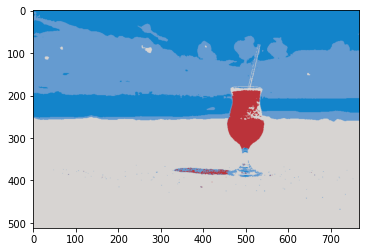

In [ ]:
pixels_new = np.zeros(pixels.shape)

for i in range(k):
  pixels_new[clusters==i] = centroids_new[i]

pixels_new = np.uint8(pixels_new)
result_img = pixels_new.reshape(img.shape)
imshow(result_img)

## T2. k-means using Scikit-learn

Now we use [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for the same image segmentation task. 
Complete the code below and show the segmented image with k = 3 using KMeans.


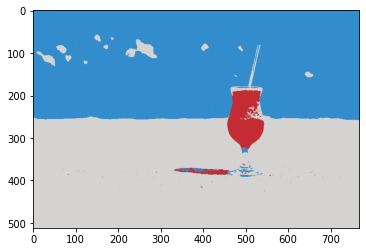

In [ ]:
from sklearn.cluster import KMeans
from matplotlib.pyplot import imshow
import cv2
import numpy as np
import imutils

# load an image from a url
img_url = 'https://snappygoat.com/b/5e3c07f2560b6420543d8e2367a70d3cdb08c39e'
img = imutils.url_to_image(img_url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pixels = img.reshape((-1,3))
pixels = np.float32(pixels)


# TODOs
k=3

kmeans = KMeans(k, random_state=0).fit(pixels)
pixels_new = np.zeros(pixels.shape)

for i in range(k):
  pixels_new[kmeans.predict(pixels) == i] = kmeans.cluster_centers_[i]

pixels_new = np.uint8(pixels_new)
result_img = pixels_new.reshape(img.shape)
imshow(result_img)